In [165]:
#Read in the necessary libraries
import pandas as pd
import numpy as np
import itertools
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import GridSearchCV
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import itertools

from matplotlib.pyplot import figure


In [120]:
#This code prevents the kernel from stopping when XGBoost is running
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

In [121]:
#Read in the datafreame
election_df = pd.read_csv('congressional_data_and_targets.csv')

## 1. Create the Boolean Target Variable

The data cleansing process was completed in the notebook titled "Census_Data_API_Work.ipynb"

In [122]:
#Create a boolean column based on whether the district voted more for the republican party or democratic party
#election_df['Target_Presidential_D_bool'] = (election_df['Target_Presidential_D'] > election_df['Target_Presidential_R']).astype(int)
election_df['Target_Presidential_R_bool'] = (election_df['Target_Presidential_R'] > election_df['Target_Presidential_D']).astype(int)


In [123]:
#Reorganize the dataframe
election_df = election_df[['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males', 'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People', 'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian', 'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin', 'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US', 'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income', 'Median_Household_Income', 'Below_Poverty_Level_LTM', 'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool', 'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree', 'Total_Married_Households', 'Total_Veterans', 'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed', 'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult', 'Total_Working_Construction', 'Total_Working_Manufacturing', 'Total_Working_Retail', 'Total_Working_Transportation', 'Total_Working_Information', 'Total_Working_Finance', 'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food', 'Total_Working_Public_Admin', 'Median_Gross_Rent', 'Previous_Presidential_D', 'Previous_Presidential_R', 'Target_Presidential_R_bool']]

## 2. EDA

In [124]:
election_df.corr()


,Total_Pop,Total_Males,Total_Females,Median_Age,Total_Children,Total_White_People,Total_Afr_Am_People,Total_American_Ind_Alk_Ntv,Total_Asian,Total_Mexican_Origin,...,Total_Working_Information,Total_Working_Finance,Total_Working_Education,Total_Working_Health,Total_Working_Food,Total_Working_Public_Admin,Median_Gross_Rent,Previous_Presidential_D,Previous_Presidential_R,Target_Presidential_R_bool
Total_Pop,1.000000,0.979734,0.978161,-0.163054,0.730508,0.422694,-0.039426,0.151612,0.082017,0.210082,...,0.179652,0.298502,0.311594,0.185917,0.390642,0.255021,0.133123,-0.194114,0.193705,0.159284
Total_Males,0.979734,1.000000,0.916703,-0.178949,0.736446,0.484302,-0.156337,0.195138,0.088398,0.265656,...,0.151000,0.246147,0.287069,0.109402,0.403458,0.256443,0.115914,-0.248092,0.243855,0.201898
Total_Females,0.978161,0.916703,1.000000,-0.139569,0.693030,0.340644,0.083579,0.099947,0.071880,0.143409,...,0.201681,0.340032,0.323684,0.257343,0.360596,0.242612,0.145272,-0.129781,0.133362,0.108236
Median_Age,-0.163054,-0.178949,-0.139569,1.000000,-0.550452,0.353550,-0.289770,-0.069666,-0.107583,-0.552772,...,-0.051839,0.064710,-0.054383,0.214071,-0.183021,-0.101921,-0.026132,-0.188566,0.193262,0.169170
Total_Children,0.730508,0.736446,0.693030,-0.550452,1.000000,0.229541,0.027793,0.153580,-0.029835,0.503361,...,-0.073174,0.045478,0.068666,-0.083715,0.144678,0.156953,-0.061777,-0.208942,0.208089,0.147906
Total_White_People,0.422694,0.484302,0.340644,0.353550,0.229541,1.000000,-0.687293,0.077432,-0.380282,-0.043652,...,-0.096790,0.114821,0.257620,0.138479,-0.015143,-0.011192,-0.284450,-0.604450,0.598784,0.481534
Total_Afr_Am_People,-0.039426,-0.156337,0.083579,-0.289770,0.027793,-0.687293,1.000000,-0.152718,-0.115123,-0.181696,...,-0.031698,-0.078095,-0.083470,0.051521,0.020869,0.146366,-0.055355,0.342246,-0.321189,-0.207045
Total_American_Ind_Alk_Ntv,0.151612,0.195138,0.099947,-0.069666,0.153580,0.077432,-0.152718,1.000000,-0.089530,0.096111,...,-0.088266,-0.120192,-0.005389,-0.020832,0.068406,0.166088,-0.118926,-0.111968,0.107407,0.117800
Total_Asian,0.082017,0.088398,0.071880,-0.107583,-0.029835,-0.380282,-0.115123,-0.089530,1.000000,0.149646,...,0.462391,0.314691,0.055357,-0.042358,0.201470,0.024413,0.718964,0.344479,-0.357680,-0.355191
Total_Mexican_Origin,0.210082,0.265656,0.143409,-0.552772,0.503361,-0.043652,-0.181696,0.096111,0.149646,1.000000,...,-0.073856,-0.147939,-0.171580,-0.366989,0.157837,-0.051691,0.104546,0.124573,-0.138668,-0.191813


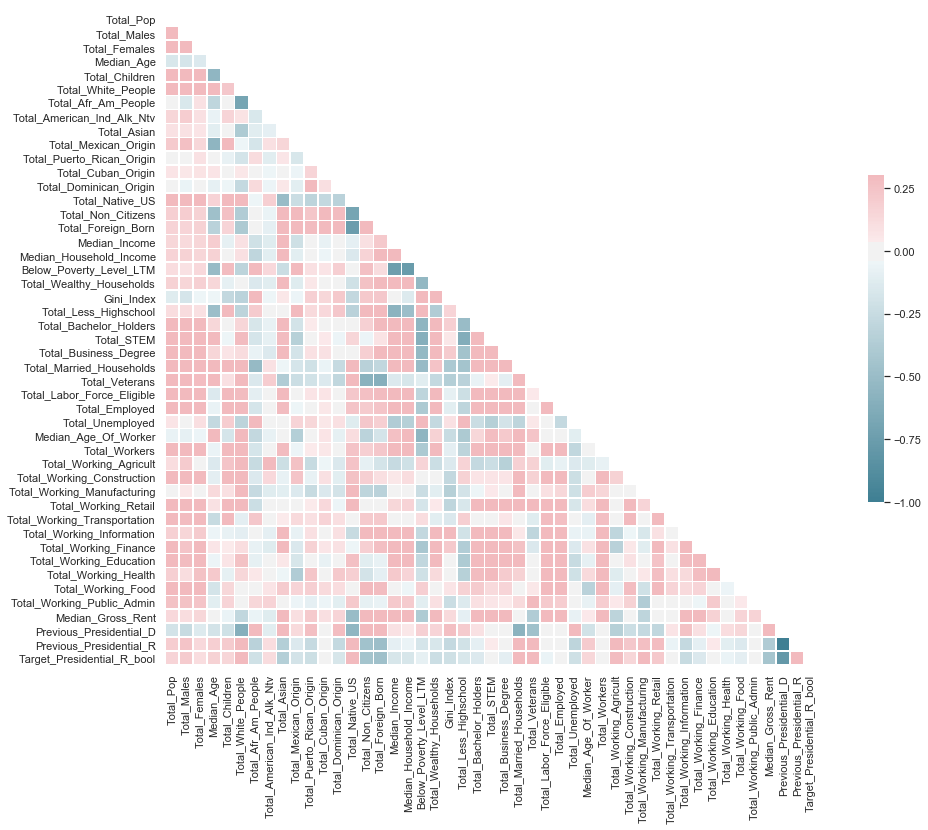

In [125]:
#A correlation matrix to determine multicollinearity
sns.set(style="white")

# Compute the correlation matrix
corr = election_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

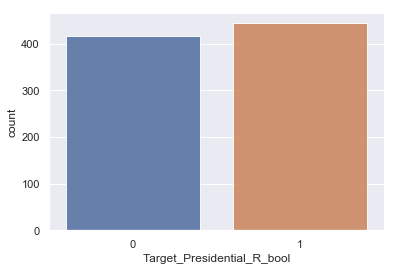

In [126]:
#A histogram of the target variable
sns.set_style('darkgrid')
sns.countplot(election_df['Target_Presidential_R_bool'], alpha=0.9)
#There is a negligible imbalance

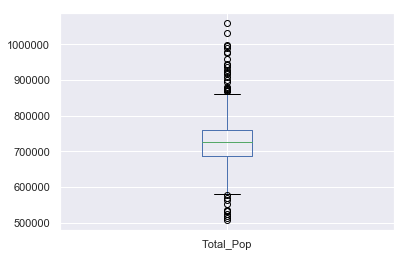

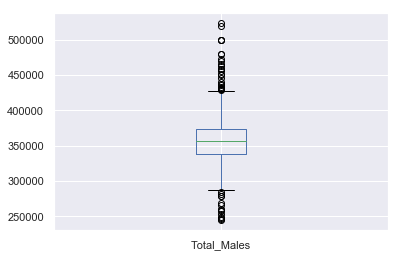

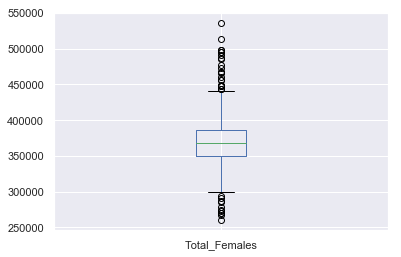

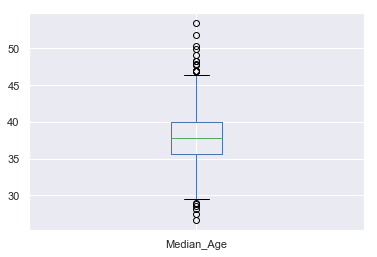

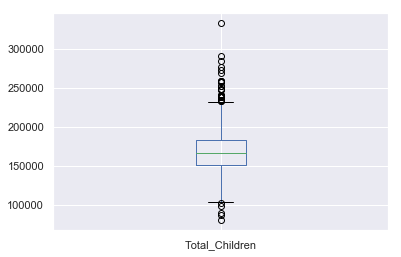

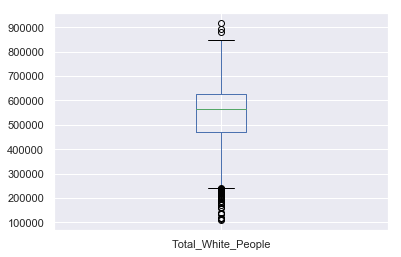

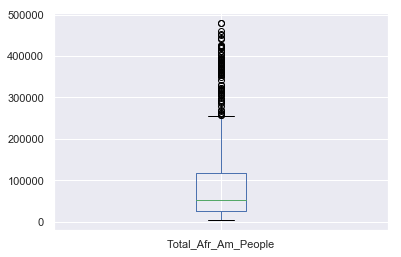

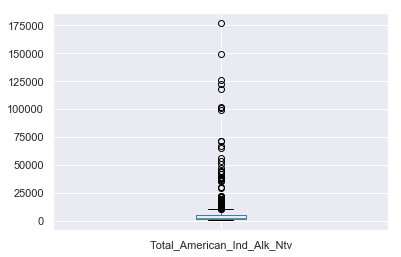

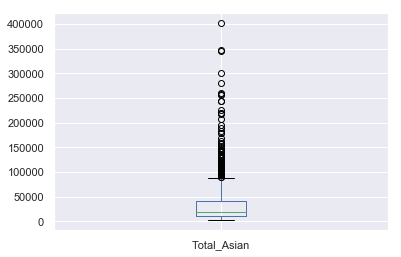

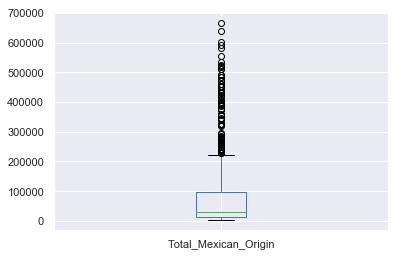

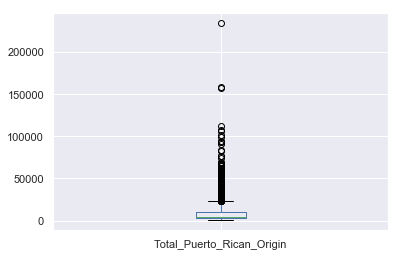

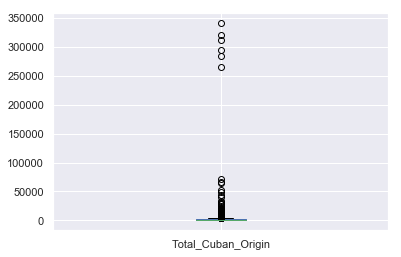

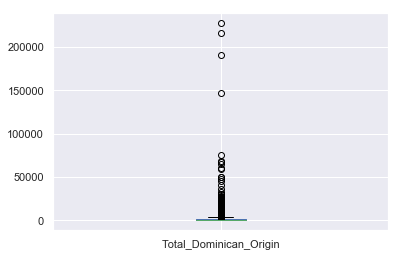

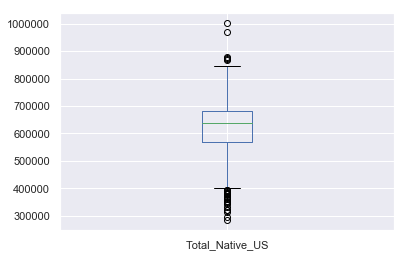

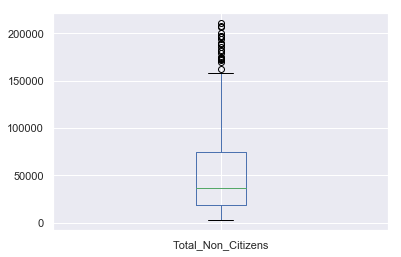

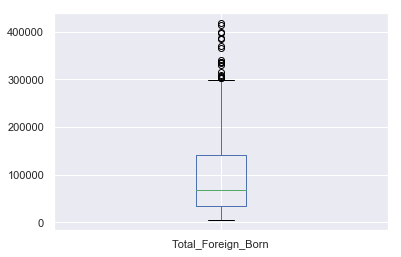

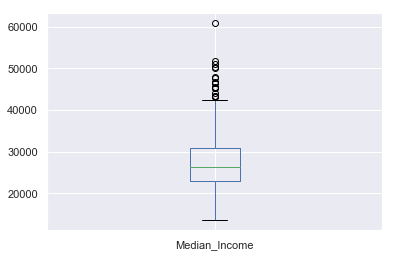

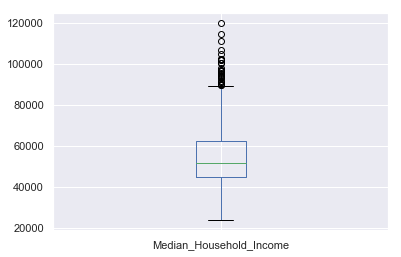

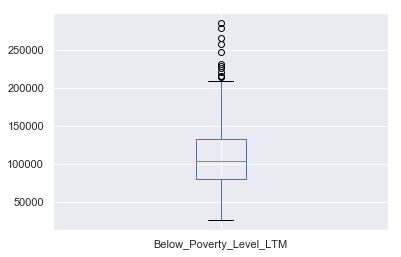

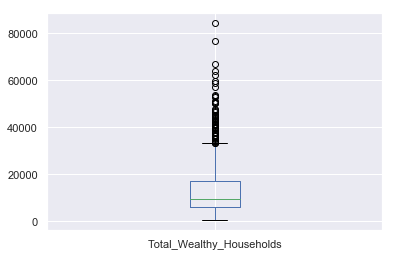

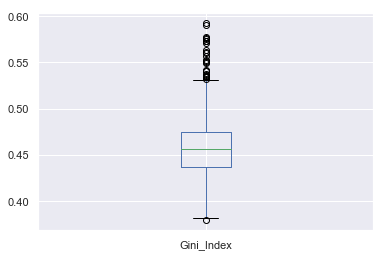

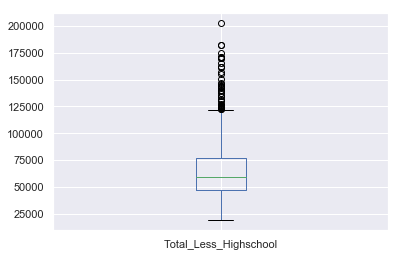

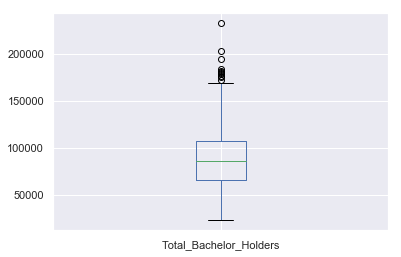

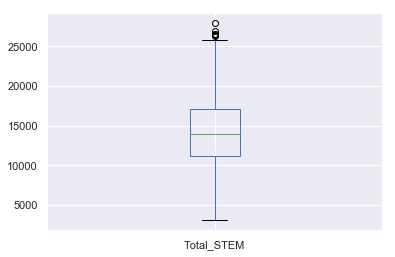

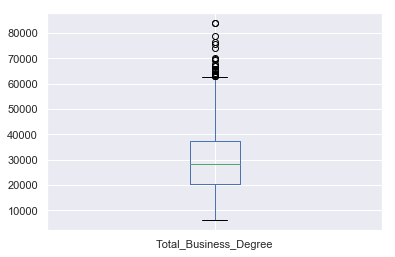

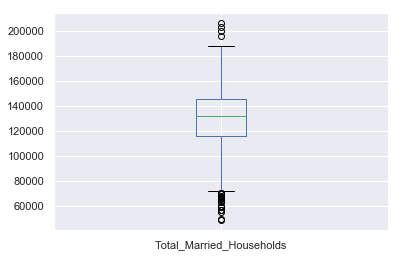

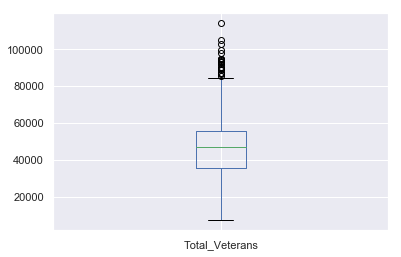

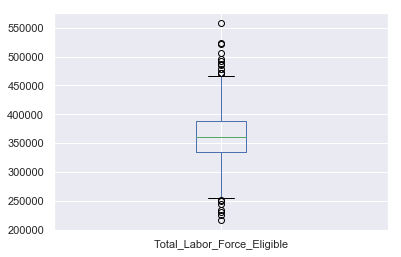

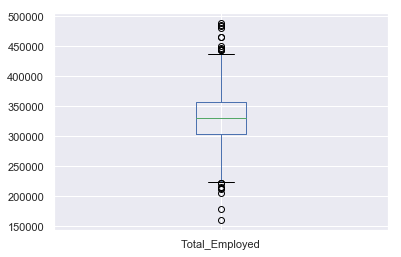

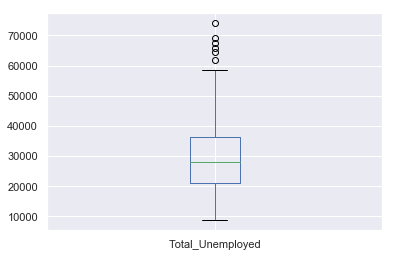

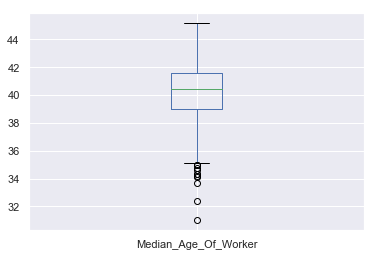

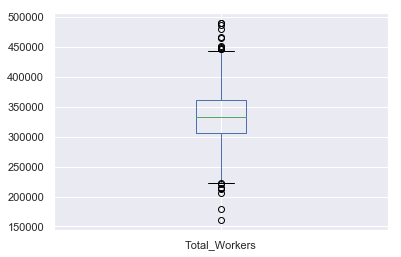

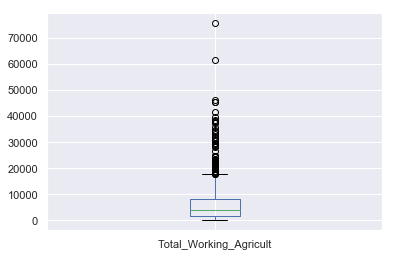

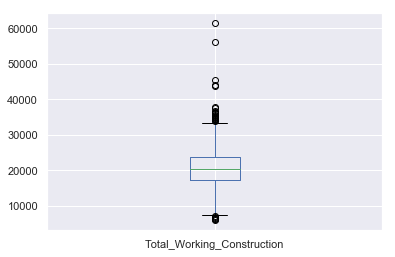

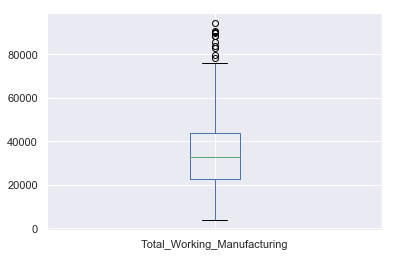

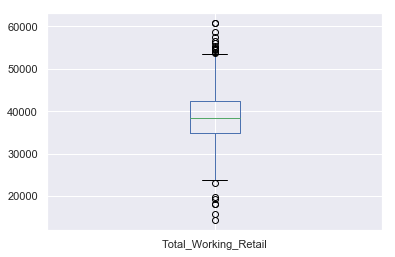

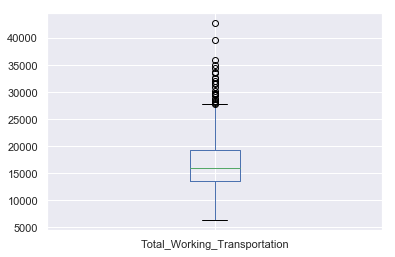

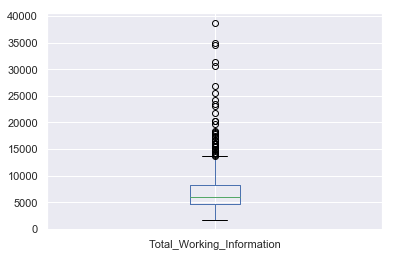

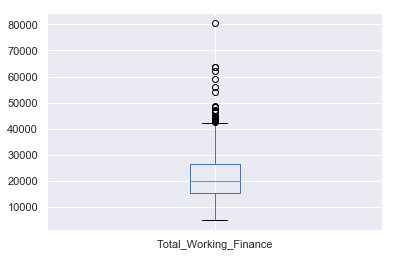

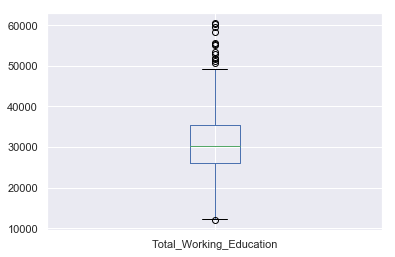

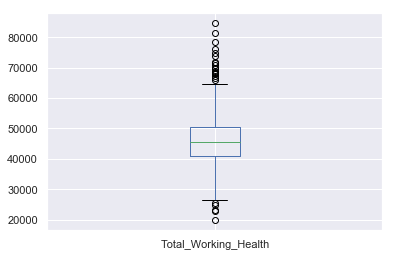

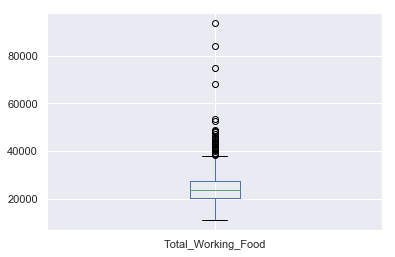

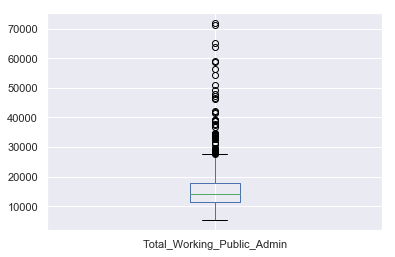

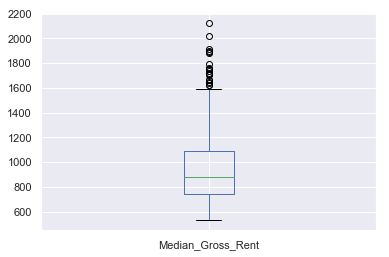

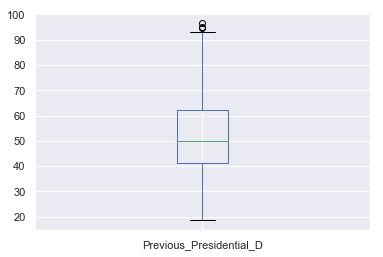

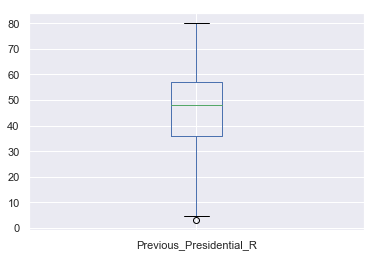

In [127]:
#Boxplots of all continuous variables
for i in election_df.columns[3:-1]:
    election_df.boxplot(column=i)
    plt.show()

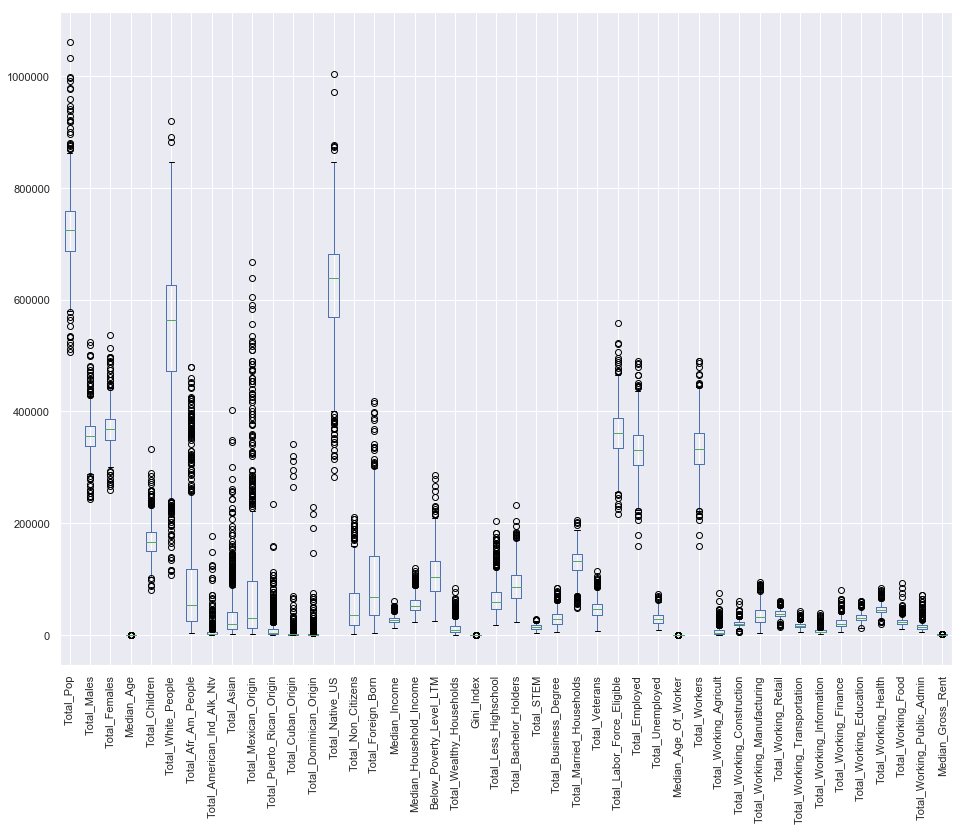

In [128]:
#A Boxplot of all continuous variables
election_df[['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males', 'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People', 'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian', 'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin', 'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US', 'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income', 'Median_Household_Income', 'Below_Poverty_Level_LTM', 'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool', 'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree', 'Total_Married_Households', 'Total_Veterans', 'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed', 'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult', 'Total_Working_Construction', 'Total_Working_Manufacturing', 'Total_Working_Retail', 'Total_Working_Transportation', 'Total_Working_Information', 'Total_Working_Finance', 'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food', 'Total_Working_Public_Admin', 'Median_Gross_Rent']].boxplot(figsize = (16,12), rot= 90)

3.A Evaluation Metrics

In [176]:
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    classes = ['Did Not Vote Republican', 'Voted Republican']
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': 22})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 3. Feature Engineering

In [129]:
election_df.describe()

,Total_Pop,Total_Males,Total_Females,Median_Age,Total_Children,Total_White_People,Total_Afr_Am_People,Total_American_Ind_Alk_Ntv,Total_Asian,Total_Mexican_Origin,...,Total_Working_Information,Total_Working_Finance,Total_Working_Education,Total_Working_Health,Total_Working_Food,Total_Working_Public_Admin,Median_Gross_Rent,Previous_Presidential_D,Previous_Presidential_R,Target_Presidential_R_bool
count,8.600000e+02,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,...,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000
mean,7.268451e+05,357600.737209,369244.387209,37.820233,169483.191860,533979.023256,92016.222093,5950.669767,37313.330233,80489.416279,...,7027.823256,21897.318605,30998.567442,45973.329070,24927.781395,16047.937209,941.208140,52.310209,46.105140,0.516279
std,6.619435e+04,34433.479928,33183.422698,3.590825,29622.251731,135143.070581,101111.608945,14154.258727,46828.288462,115513.394277,...,3957.953694,8880.305939,7304.605726,8275.721264,7152.465737,8063.942992,263.963379,15.197163,15.198029,0.500026
min,5.060360e+05,244165.000000,259717.000000,26.600000,79905.000000,108156.000000,3031.000000,204.000000,1582.000000,1644.000000,...,1572.000000,4898.000000,11937.000000,19790.000000,10929.000000,5196.000000,528.000000,18.500000,3.000000,0.000000
25%,6.869985e+05,338342.750000,349492.750000,35.700000,150886.250000,471771.000000,25725.000000,1466.500000,11112.250000,13003.750000,...,4568.000000,15569.250000,26153.750000,40786.000000,20498.250000,11266.750000,740.750000,41.200000,36.000000,0.000000
50%,7.251775e+05,356798.000000,367634.500000,37.800000,166010.500000,562842.000000,52870.000000,2542.000000,19595.500000,29654.500000,...,6045.000000,20156.500000,30256.500000,45551.000000,23704.500000,14209.000000,875.500000,50.000000,48.200000,1.000000
75%,7.589910e+05,374238.500000,386822.250000,40.025000,183537.500000,626446.000000,117343.500000,5004.000000,41617.000000,96621.750000,...,8227.500000,26312.750000,35481.500000,50479.500000,27580.500000,17775.500000,1092.750000,62.350000,57.200000,1.000000
max,1.060651e+06,524241.000000,536410.000000,53.500000,333258.000000,918701.000000,480259.000000,177468.000000,402466.000000,667403.000000,...,38750.000000,80628.000000,60628.000000,84767.000000,93824.000000,71974.000000,2126.000000,96.700000,80.200000,1.000000


In [130]:
election_df_feature_engineering = election_df.copy()
election_df_feature_engineering.columns

Index(['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males',
       'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
       'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
       'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
       'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
       'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
       'Median_Household_Income', 'Below_Poverty_Level_LTM',
       'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
       'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
       'Total_Married_Households', 'Total_Veterans',
       'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
       'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult',
       'Total_Working_Construction', 'Total_Working_Manufacturing',
       'Total_Working_Retail', 'Total_Working_Transportation',
       'Total_Working_Informat

In [131]:
#Create booleans if more than fifteen percent of a district's labor force work in a specific industry
election_df_feature_engineering['Ten_Percent_Manufacturing'] = np.where(election_df_feature_engineering['Total_Working_Manufacturing']/election_df_feature_engineering['Total_Workers']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Manufacturing.value_counts())

election_df_feature_engineering['Ten_Percent_Agricult'] = np.where(election_df_feature_engineering['Total_Working_Agricult']/election_df_feature_engineering['Total_Workers']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Agricult.value_counts())

election_df_feature_engineering['Ten_Percent_Construction'] = np.where(election_df_feature_engineering['Total_Working_Construction']/election_df_feature_engineering['Total_Workers']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Construction.value_counts())

election_df_feature_engineering['Ten_Percent_Retail'] = np.where(election_df_feature_engineering['Total_Working_Retail']/election_df_feature_engineering['Total_Workers']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Retail.value_counts())

election_df_feature_engineering['Ten_Percent_Information'] = np.where(election_df_feature_engineering['Total_Working_Information']/election_df_feature_engineering['Total_Workers']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Information.value_counts())

election_df_feature_engineering['Ten_Percent_Transportation'] = np.where(election_df_feature_engineering['Total_Working_Transportation']/election_df_feature_engineering['Total_Workers']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Transportation.value_counts())

election_df_feature_engineering['Ten_Percent_Finance'] = np.where(election_df_feature_engineering['Total_Working_Finance']/election_df_feature_engineering['Total_Workers']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Finance.value_counts())

election_df_feature_engineering['Ten_Percent_Education'] = np.where(election_df_feature_engineering['Total_Working_Education']/election_df_feature_engineering['Total_Workers']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Education.value_counts())

election_df_feature_engineering['Ten_Percent_Health'] = np.where(election_df_feature_engineering['Total_Working_Health']/election_df_feature_engineering['Total_Workers']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Health.value_counts())

election_df_feature_engineering['Ten_Percent_Food'] = np.where(election_df_feature_engineering['Total_Working_Food']/election_df_feature_engineering['Total_Workers']>=0.1, 1, 0)
print(election_df_feature_engineering.Ten_Percent_Food.value_counts())


#Drops the columns that the above booleans were derived from
election_df_feature_engineering.drop(['Total_Working_Agricult',
       'Total_Working_Construction', 'Total_Working_Manufacturing',
       'Total_Working_Retail', 'Total_Working_Transportation',
       'Total_Working_Information', 'Total_Working_Finance',
       'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food',
       'Total_Working_Public_Admin'], axis=1)


0    438
1    422
Name: Ten_Percent_Manufacturing, dtype: int64
0    847
1     13
Name: Ten_Percent_Agricult, dtype: int64
0    846
1     14
Name: Ten_Percent_Construction, dtype: int64
1    771
0     89
Name: Ten_Percent_Retail, dtype: int64
0    860
Name: Ten_Percent_Information, dtype: int64
0    853
1      7
Name: Ten_Percent_Transportation, dtype: int64
0    803
1     57
Name: Ten_Percent_Finance, dtype: int64
0    605
1    255
Name: Ten_Percent_Education, dtype: int64
1    826
0     34
Name: Ten_Percent_Health, dtype: int64
0    797
1     63
Name: Ten_Percent_Food, dtype: int64


,CD_Id_Year,District_Name,State,Total_Pop,Total_Males,Total_Females,Median_Age,Total_Children,Total_White_People,Total_Afr_Am_People,...,Ten_Percent_Manufacturing,Ten_Percent_Agricult,Ten_Percent_Construction,Ten_Percent_Retail,Ten_Percent_Information,Ten_Percent_Transportation,Ten_Percent_Finance,Ten_Percent_Education,Ten_Percent_Health,Ten_Percent_Food
0,CT-01-2016,"Congressional District 1 (114th Congress), Con...",CT,711436,341326,370110,41.0,147905,497769,110721,...,1,0,0,1,0,0,1,0,1,0
1,CT-02-2016,"Congressional District 2 (114th Congress), Con...",CT,709647,356636,353011,41.4,138456,605885,29651,...,1,0,0,1,0,0,0,1,1,0
2,CT-03-2016,"Congressional District 3 (114th Congress), Con...",CT,720493,347519,372974,39.0,147105,526161,95429,...,1,0,0,1,0,0,0,1,1,0
3,CT-04-2016,"Congressional District 4 (114th Congress), Con...",CT,736742,356360,380382,39.7,174873,537381,95726,...,0,0,0,1,0,0,1,0,1,0
4,CT-05-2016,"Congressional District 5 (114th Congress), Con...",CT,712568,350222,362346,41.8,154986,580747,49044,...,1,0,0,1,0,0,0,1,1,0
5,DE-AL-2016,Congressional District (at Large) (114th Congr...,DE,945934,458208,487726,39.7,204200,654904,203863,...,0,0,0,1,0,0,0,0,1,0
6,DC-98-2016,"Delegate District (at Large) (114th Congress),...",DC,672228,319705,352523,33.8,117838,269143,318831,...,0,0,0,0,0,0,0,1,0,0
7,FL-01-2016,"Congressional District 1 (114th Congress), Flo...",FL,750928,379933,370995,38.5,158814,578965,98282,...,0,0,0,1,0,0,0,0,1,1
8,FL-02-2016,"Congressional District 2 (114th Congress), Flo...",FL,718173,361387,356786,36.5,142212,497970,179656,...,0,0,0,1,0,0,0,1,1,1
9,FL-03-2016,"Congressional District 3 (114th Congress), Flo...",FL,721105,358340,362765,37.9,149040,569233,98797,...,0,0,0,1,0,0,0,1,1,0


In [132]:
#Drop boolean columns that contain only zeros
election_df_feature_engineering = election_df_feature_engineering.drop(['Total_Working_Agricult',
       'Total_Working_Construction', 'Total_Working_Manufacturing',
       'Total_Working_Retail', 'Total_Working_Transportation',
       'Total_Working_Information', 'Total_Working_Finance',
       'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food',
       'Total_Working_Public_Admin'], axis=1)

#Drop information because no district contains more than ten percent of the labor force working in that field
election_df_feature_engineering = election_df_feature_engineering.drop(['Ten_Percent_Information'], axis=1)

In [133]:
election_df_feature_engineering.columns

Index(['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males',
       'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
       'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
       'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
       'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
       'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
       'Median_Household_Income', 'Below_Poverty_Level_LTM',
       'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
       'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
       'Total_Married_Households', 'Total_Veterans',
       'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
       'Median_Age_Of_Worker', 'Total_Workers', 'Median_Gross_Rent',
       'Previous_Presidential_D', 'Previous_Presidential_R',
       'Target_Presidential_R_bool', 'Ten_Percent_Manufacturing',
       'Ten_Percent_Agricult', 'Ten_Per

In [134]:
test['TWH_Less_BPL_Divby_SqRt_Age'] = (test.Total_Wealthy_Households - test.Below_Poverty_Level_LTM)/np.sqrt(test.Median_Age)
test['TWH_Less_BPL_Divby_SqRt_Age'].describe()

count      860.000000
mean    -15684.934222
std       8199.870088
min     -51185.640380
25%     -20402.139452
50%     -14974.039919
75%     -10281.656760
max       4054.281840
Name: TWH_Less_BPL_Divby_SqRt_Age, dtype: float64

In [135]:
#Reorganize the dataframe
election_df_feature_engineering = election_df_feature_engineering[['CD_Id_Year', 'District_Name', 'State', 'Total_Pop', 'Total_Males',
       'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
       'Total_Afr_Am_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
       'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
       'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
       'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
       'Median_Household_Income', 'Below_Poverty_Level_LTM',
       'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
       'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
       'Total_Married_Households', 'Total_Veterans',
       'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
       'Median_Age_Of_Worker', 'Total_Workers', 'Ten_Percent_Manufacturing',
       'Ten_Percent_Agricult', 'Ten_Percent_Construction',
       'Ten_Percent_Retail', 'Ten_Percent_Transportation',
       'Ten_Percent_Finance', 'Ten_Percent_Education', 'Ten_Percent_Health',
       'Ten_Percent_Food', 'Median_Gross_Rent',
       'Previous_Presidential_D', 'Previous_Presidential_R', 'Target_Presidential_R_bool']]

## 4. Initial Regression - Without Feature Engineering

In [136]:
#This is an initial logistic regression of all dependent variables using Scikit learn
#Using the dataframe without feature engineering

#Split data to be used in the models
# Create matrix of features
# X will take every dependent variable but the target and other index variables
X_log_model_1 = election_df.drop(['Target_Presidential_R_bool','CD_Id_Year', 'District_Name', 'State'], axis = 1) 

# Create target variable
y_log_model_1 = election_df['Target_Presidential_R_bool'] # y is the column we're trying to predict

In [137]:
# Use x and y variables to split the training data into train and test set
X_train_log_model_1, X_test_log_model_1, y_train_log_model_1, y_test_log_model_1 = train_test_split(X_log_model_1, y_log_model_1, random_state=1, )

In [138]:
#Fit the model and view the coefficients
log_model_1 = LogisticRegression(C=1e9)
log_model_1.fit(X_train_log_model_1, y_train_log_model_1)
zip(X_train_log_model_1.columns, log_model_1.coef_[0])
log_model_1.coef_

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


array([[-4.53877083e-05,  2.17186029e-05, -6.71063113e-05,
        -3.63146324e-04,  3.74051973e-05,  1.27196335e-05,
         6.18345140e-06,  1.09501521e-05,  8.27477576e-06,
        -1.29196304e-05,  9.19537111e-06, -9.80918820e-06,
        -1.21455044e-05,  5.66057174e-05, -5.17280380e-05,
         8.14219317e-05, -1.04959764e-04, -4.60832220e-06,
        -1.12981363e-06, -6.01679897e-06,  6.42623628e-06,
         3.16568478e-05,  1.06573520e-05, -2.88004420e-05,
         6.32992449e-05,  5.49880059e-06,  1.93996016e-05,
        -1.76057584e-05,  2.67457083e-05, -4.43514668e-05,
        -1.97136255e-04, -4.10198236e-05,  6.12329892e-05,
         3.54898994e-05,  3.38815934e-05,  9.59155375e-05,
         3.60296357e-05, -4.91383278e-05,  3.24078167e-05,
         3.85006186e-05, -5.84562924e-05,  4.35350745e-05,
         1.82246342e-05, -6.55817602e-04, -1.70273528e-02,
         1.75505000e-02]])

In [139]:
# class predictions (not predicted probabilities)
y_pred_class_log_model_1 = log_model_1.predict(X_test_log_model_1)

#Calculate the model's accuracy
print(metrics.accuracy_score(y_test_log_model_1, y_pred_class_log_model_1))

0.8093023255813954


In [153]:
# save confusion matrix and slice into four pieces
confusion_log_model_1 = metrics.confusion_matrix(y_test_log_model_1, y_pred_class_log_model_1)
TP_log_model_1 = confusion_log_model_1[1][1]
TN_log_model_1 = confusion_log_model_1[0][0]
FP_log_model_1 = confusion_log_model_1[0][1]
FN_log_model_1 = confusion_log_model_1[1][0]

print('Log Model 1 Confusion Matrix:')
print ('True Positives:', TP_log_model_1)
print ('True Negatives:', TN_log_model_1)
print ('False Positives:', FP_log_model_1)
print ('False Negatives:', FN_log_model_1)

Log Model 1 Confusion Matrix:
True Positives: 88
True Negatives: 86
False Positives: 22
False Negatives: 19


Confusion Matrix, without normalization


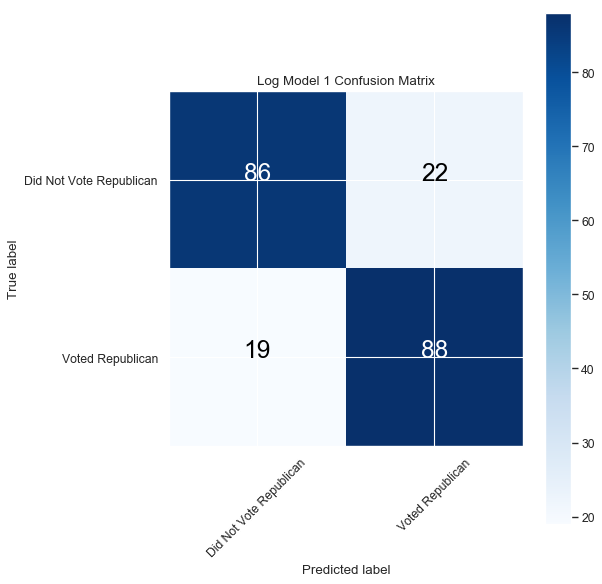

In [181]:
plot_confusion_matrix(confusion_log_model_1,
                          normalize=False,
                          title='Log Model 1 Confusion Matrix',
                          cmap=plt.cm.Blues)

## 5. Initial Regression - With Feature Engineering

In [154]:
#This is an initial logistic regression of all dependent variables using Scikit learn
#Using the dataframe without feature engineering

#Split data to be used in the models
# Create matrix of features
# X will take every dependent variable but the target and other index variables
X_log_model_2 = election_df_feature_engineering.drop(['Target_Presidential_R_bool','CD_Id_Year', 'District_Name', 'State'], axis = 1) 

# Create target variable
y_log_model_2 = election_df_feature_engineering['Target_Presidential_R_bool'] # y is the column we're trying to predict

In [155]:
# Use x and y variables to split the training data into train and test set
X_train_log_model_2, X_test_log_model_2, y_train_log_model_2, y_test_log_model_2 = train_test_split(X_log_model_2, y_log_model_2, random_state=1)

In [156]:
#Fit the model and view the coefficients
log_model_2 = LogisticRegression(C=1e9)
log_model_2.fit(X_train_log_model_2, y_train_log_model_2)
zip(X_train_log_model_2.columns, log_model_2.coef_[0])
log_model_2.coef_

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


array([[-2.83835973e-05,  3.03793218e-05, -5.87629200e-05,
        -1.00359304e-03,  2.25173640e-05,  9.00797406e-06,
         4.94785617e-06,  6.42260746e-06,  4.39742908e-06,
        -1.02441226e-05,  4.99200278e-06, -1.27127163e-05,
        -7.88396481e-06,  3.90588085e-05, -3.55178829e-05,
         6.06005349e-05, -1.08555395e-04,  2.89184302e-06,
        -2.32849156e-06, -3.58590325e-05,  2.76182501e-05,
         1.73155834e-05,  2.92944905e-06, -7.49596473e-05,
         4.32497099e-05,  8.95951889e-06,  3.34378957e-06,
        -2.01839852e-05,  3.42618186e-06, -2.36101673e-05,
        -4.65593540e-04,  1.03281379e-05, -3.03816780e-04,
        -2.22653560e-05, -3.41198275e-05,  2.24719524e-04,
        -3.62503174e-06,  1.18574120e-04, -2.09568306e-04,
        -7.48967357e-05,  1.85543658e-04, -1.00838994e-03,
        -6.36451333e-02,  6.63639843e-02]])

In [157]:
# class predictions (not predicted probabilities)
y_pred_class_log_model_2 = log_model_2.predict(X_test_log_model_2)

#Calculate the model's accuracy
print(metrics.accuracy_score(y_test_log_model_2, y_pred_class_log_model_2))

0.8976744186046511


In [158]:
# save confusion matrix and slice into four pieces
confusion_log_model_2 = metrics.confusion_matrix(y_test_log_model_2, y_pred_class_log_model_2)
TP_log_model_2 = confusion_log_model_1[1][1]
TN_log_model_2 = confusion_log_model_1[0][0]
FP_log_model_2 = confusion_log_model_1[0][1]
FN_log_model_2 = confusion_log_model_1[1][0]

print('Log Model 2 Confusion Matrix:')
print ('True Positives:', TP_log_model_2)
print ('True Negatives:', TN_log_model_2)
print ('False Positives:', FP_log_model_2)
print ('False Negatives:', FN_log_model_2)

Log Model 2 Confusion Matrix:
True Positives: 88
True Negatives: 86
False Positives: 22
False Negatives: 19


Confusion Matrix, without normalization


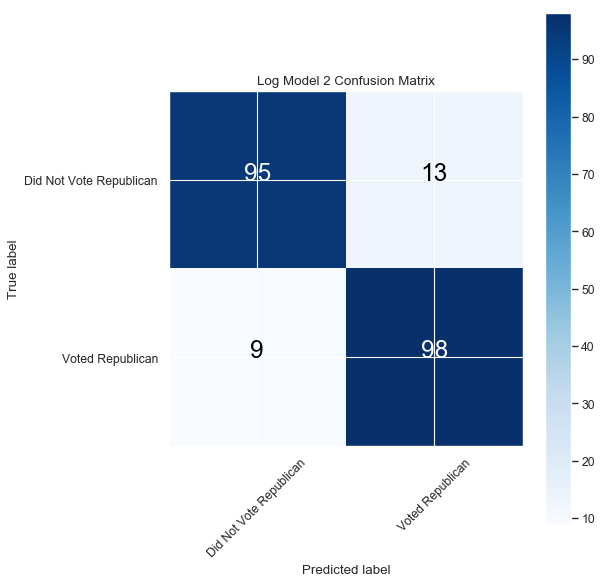

In [185]:
plot_confusion_matrix(confusion_log_model_2,
                          normalize=False,
                          title='Log Model 2 Confusion Matrix',
                          cmap=plt.cm.Blues)

In [186]:
#The feature engineering work improved the initial model by
log_model_1_accuracy = metrics.accuracy_score(y_test_log_model_1, y_pred_class_log_model_1)
log_model_2_accuracy = metrics.accuracy_score(y_test_log_model_2, y_pred_class_log_model_2)
delta_models =  log_model_2_accuracy-log_model_1_accuracy

print("The feature engineering improved the initial model's accuracy by {}.".format(delta_models))

The feature engineering improved the initial model's accuracy by 0.08837209302325577.


In [ ]:
#A correlation matrix to determine multicollinearity
sns.set(style="white")

# Compute the correlation matrix
corr = test.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
def reset_data():
    df = pd.read_csv('congressional_data_and_targets.csv')
    
    #Create a boolean column based on whether the district voted more for the republican party or democratic party
    df['Target_Presidential_D_bool'] = (df['Target_Presidential_D'] > df['Target_Presidential_R']).astype(int)

    
    y = df.Target_Presidential_R_bool
    X = df[['Total_Pop', 'Total_Males',
       'Total_Females', 'Median_Age', 'Total_Children', 'Total_White_People',
       'Total_Black_People', 'Total_American_Ind_Alk_Ntv', 'Total_Asian',
       'Total_Hispanic', 'Total_Mexican_Origin', 'Total_Puerto_Rican_Origin',
       'Total_Cuban_Origin', 'Total_Dominican_Origin', 'Total_Native_US',
       'Total_Non_Citizens', 'Total_Foreign_Born', 'Median_Income',
       'Median_Household_Income', 'Below_Poverty_Level_LTM',
       'Total_Wealthy_Households', 'Gini_Index', 'Total_Less_Highschool',
       'Total_Bachelor_Holders', 'Total_STEM', 'Total_Business_Degree',
       'Total_Married_Households', 'Total_Veterans',
       'Total_Labor_Force_Eligible', 'Total_Employed', 'Total_Unemployed',
       'Median_Age_Of_Worker', 'Total_Workers', 'Total_Working_Agricult',
       'Total_Working_Construction', 'Total_Working_Manufacturing',
       'Total_Working_Retail', 'Total_Working_Transportation',
       'Total_Working_Information', 'Total_Working_Finance',
       'Total_Working_Education', 'Total_Working_Health', 'Total_Working_Food',
       'Total_Working_Public_Admin', 'Median_Gross_Rent','Previous_Presidential_D', 'Previous_Presidential_R']]
    
    return train_test_split(X, y, random_state=1, test_size = 0.2)


In [ ]:
X_train, X_test, y_train, y_test =  reset_data()

sc=StandardScaler()
X_train_scaled= sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [ ]:
# Create logistic regression
logistic = linear_model.LogisticRegression()

In [ ]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = C_param_range = [0.001,0.01,0.1, 0.5, 1, 2, 5, 10]

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [ ]:
# Create grid search using 5-fold cross validation
clf_gs = GridSearchCV(logistic, hyperparameters, cv=5, scoring= "f1") 

In [ ]:
# Fit grid search
model = clf_gs.fit(X_train_scaled, y_train) 

In [ ]:
# View best hyperparameters
print('Best Penalty:', model.best_estimator_.get_params()['penalty'])
print('Best C:', model.best_estimator_.get_params()['C'])

In [ ]:
y_pred_train = model.best_estimator_.predict(X_train_scaled)

y_pred_test = model.best_estimator_.predict(X_test_scaled)

# Model Accuracy, how often is the classifier correct?
print("Training F1 Score:",metrics.f1_score(y_train, y_pred_train))
print("Testing F1 Score:",metrics.f1_score(y_test, y_pred_test))

In [ ]:
## training the model
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1, normalize=False)
#Alpha is lambda here, the penalty of having more coefficients


lasso.fit(X_train,y_train)

y_train_pred = lasso.predict(X_train)
y_pred = lasso.predict(X_test)

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Training Error: '+ str(train_rmse) )
print('Testing Error: '+ str(test_rmse) )

In [ ]:
lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

In [ ]:
#election_df.sort_values(by='Total_Hispanic', ascending=False)


In [ ]:
# Create list of columns which will be interrograted for outlier removal 
#outlier_cols = election_df[election_df.select_dtypes(include='int64').columns].columns.tolist()
#outlier_cols.remove('Target_Presidential_D_bool')
#outlier_cols.remove('Target_Presidential_R_bool')
#outlier_cols

In [ ]:
#election_df[outlier_cols].describe().transpose()

In [ ]:
# Remove outliers > 3 Standard Deviations
#election_df = election_df[(np.abs(stats.zscore(election_df[outlier_cols])) < 3).all(axis=1)]
#election_df.shape

In [ ]:
election_df.columns

In [ ]:
# Drop unecessary columns
election_df.drop(['CD_Id_Year', 'District_Name', 'State','Target_Presidential_D_bool','Previous_Presidential_R', 'Previous_Presidential_D'], axis = 1, inplace = True)

# Shape of train data
print('train_data shape',election_df.shape)

# Create matrix of features
X = election_df.drop('Target_Presidential_R_bool', axis = 1) # grabs everything else but 'Survived'

# Create target variable
y = election_df['Target_Presidential_R_bool'] # y is the column we're trying to predict

# Create a list of the features being used in the 
feature_cols = X.columns

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

from sklearn.preprocessing import StandardScaler

sc=StandardScaler()
X_train_scaled= sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

In [ ]:
# Create logistic regression
logistic = linear_model.LogisticRegression()

In [ ]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = C_param_range = [0.001,0.01,0.1, 0.5, 1, 2, 5, 10,]

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [ ]:

# Create grid search using 5-fold cross validation
clf_gs = GridSearchCV(logistic, hyperparameters, cv=5, scoring='f1') 

In [ ]:
# Fit grid search
model = clf_gs.fit(X_train_scaled, y_train)

In [ ]:
# View best hyperparameters
print('Best Penalty:', model.best_estimator_.get_params()['penalty'])
print('Best C:', model.best_estimator_.get_params()['C'])

In [ ]:
y_pred_train = model.best_estimator_.predict(X_train_scaled)

y_pred_test = model.best_estimator_.predict(X_test_scaled)

# Model Accuracy, how often is the classifier correct?
print("Training F1 Score:",metrics.f1_score(y_train, y_pred_train))
print("Testing F1 Score:",metrics.f1_score(y_test, y_pred_test))

In [ ]:
X.columns

In [ ]:
# Sort feature importances in descending order

model_params = list(zip(feature_cols, model.best_estimator_.coef_[0]))

model_params.sort(key = lambda x: abs(x[1]), reverse=True)
model_params

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  

# Rearrange feature names so they match the sorted feature importances
model_features = [i[0] for i in model_params]

feature_weights = [abs(i[1]) for i in model_params]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(model_features, feature_weights)

# Add feature names as x-axis labels
# plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#predict the training set
y_pred_train = clf.predict(X_train)

#Predict the response for test dataset
y_pred_test = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Training F1 Score:",metrics.f1_score(y_train, y_pred_train))
print("Testing F1 Score:",metrics.f1_score(y_test, y_pred_test))

In [ ]:
# Calculate feature importances
importances = clf.feature_importances_

 
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [feature_cols[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()